# Модели за динамика на популација
### Содржина

* [I. Логистичка равенка - Пандемија на SARS-CoV-2 во Народна Република Кина](#chapter1)
* [II. Модел за интерспециска конкуренција - Експеримент на Gause со Paramecium](#chapter2)
    * [II.1 Интраспециска конкуренција на P. aurelia и P. caudatum](#section_2_1)
    * [II.2 Интерспециска конкуренција на P. aurelia и P. caudatum](#section_2_2)
* [III. Модел за предаторство - Hudson Bay Company](#chapter3)
    * [III.1 Анализа на податоци](#section_3_1)
    * [III.2 Симулација на системот](#section_3_2)

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, minimize, minimize_scalar, least_squares
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### I. Логистичка равенка <a class="anchor" id="chapter1"></a>

$ \frac{dN}{dt}=rN\left(1-{\frac{N}{K}}\right) $

$ N(t)={\frac{K}{1+\frac{K-N_{0}}{N_{0}}e^{-rt}}} $

In [2]:
# Fitting function
def logistic_growth(t, K, r, N0):
    return K / (1 + ((K-N0)/N0)*np.exp(-r*t))

### II. Модел за интерспециска конкуренција - Експеримент на Gause со Paramecium <a class="anchor" id="chapter2"></a>
#### II.1 Интраспециска конкуренција на P. aurelia и P. caudatum <a class="anchor" id="section_2_1"></a>

In [3]:
par = pd.read_csv('paramecium_data-Copy.txt', '\t')
par

,Time,Paramecium aurelia,Paramecium caudatum,Paramecium aurelia competition,Paramecium caudatum competition
0,0,2.0,2,2,2.0
1,1,3.0,5,4,8.0
2,2,29.0,22,29,20.0
3,3,92.0,16,66,25.0
4,4,173.0,39,141,24.0
5,5,210.0,52,162,NaN
6,6,210.0,54,219,NaN
7,7,240.0,47,153,NaN
8,8,NaN,50,162,21.0
9,9,NaN,26,150,15.0


In [4]:
par['Paramecium aurelia'] = par['Paramecium aurelia'].interpolate(method='nearest')
par['Paramecium caudatum competition'] = par['Paramecium caudatum competition'].interpolate(method='nearest')

In [5]:
par.insert(2, 'Paramecium aurelia * 0.39', 0.39 * par['Paramecium aurelia'])
par.insert(5, 'Paramecium aurelia competition * 0.39', 0.39 * par['Paramecium aurelia competition'])

In [6]:
par

,Time,Paramecium aurelia,Paramecium aurelia * 0.39,Paramecium caudatum,Paramecium aurelia competition,Paramecium aurelia competition * 0.39,Paramecium caudatum competition
0,0,2.0,0.78,2,2,0.78,2.0
1,1,3.0,1.17,5,4,1.56,8.0
2,2,29.0,11.31,22,29,11.31,20.0
3,3,92.0,35.88,16,66,25.74,25.0
4,4,173.0,67.47,39,141,54.99,24.0
5,5,210.0,81.90,52,162,63.18,24.0
6,6,210.0,81.90,54,219,85.41,24.0
7,7,240.0,93.60,47,153,59.67,21.0
8,8,240.0,93.60,50,162,63.18,21.0
9,9,240.0,93.60,26,150,58.50,15.0


### Preprocess dataset

In [7]:
par1 = par.copy(deep=True)

In [8]:
par1 = par1.drop(['Paramecium aurelia', 'Paramecium aurelia competition'], axis=1)

In [9]:
par1 = par1.rename(columns={'Time': 't',
                     'Paramecium aurelia * 0.39': 'x',
                     'Paramecium caudatum': 'y',
                     'Paramecium aurelia competition * 0.39': 'x_comp',
                     'Paramecium caudatum competition': 'y_comp'})

In [10]:
par1

,t,x,y,x_comp,y_comp
0,0,0.78,2,0.78,2.0
1,1,1.17,5,1.56,8.0
2,2,11.31,22,11.31,20.0
3,3,35.88,16,25.74,25.0
4,4,67.47,39,54.99,24.0
5,5,81.90,52,63.18,24.0
6,6,81.90,54,85.41,24.0
7,7,93.60,47,59.67,21.0
8,8,93.60,50,63.18,21.0
9,9,93.60,26,58.50,15.0


94.68708 1.26055 1.25975


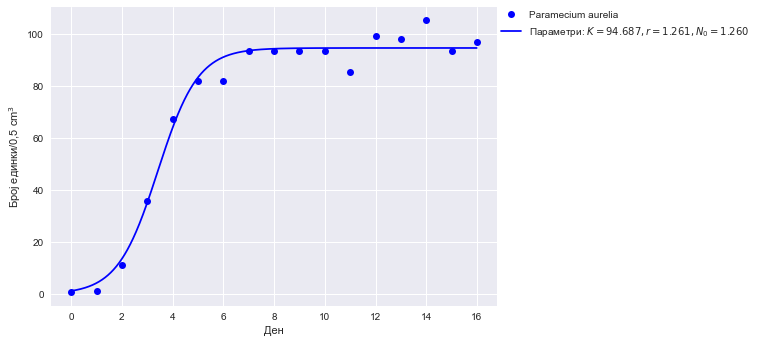

In [11]:
# Experimental data
t = par1['t'].values
x = par1['x'].values

# Plot experimental data points
plt.plot(t, x, 'bo', label='Paramecium aurelia')
 
# Initial guess for the parameters
initialGuess = [x[-1],1,1]    
 
# Perform the curve-fit
poptAurelia, pcovAuerlia = curve_fit(f=logistic_growth, xdata=t, ydata=x, p0=initialGuess)
poptAurelia = np.round(poptAurelia, 5)
print(*poptAurelia)
 
# x values for the fitted function
t_calc = np.arange(0.0,16.0,0.01)
 
# Plot the fitted function
plt.plot(t_calc, logistic_growth(t_calc, *poptAurelia), 'b', label='Параметри: $K=%5.3f, r=%5.3f, N_0=%5.3f$' % tuple(poptAurelia))
plt.xlabel('Ден')
plt.ylabel('Број единки/0,5 cm$^3$')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

[54.88212  0.90059  2.9793 ]


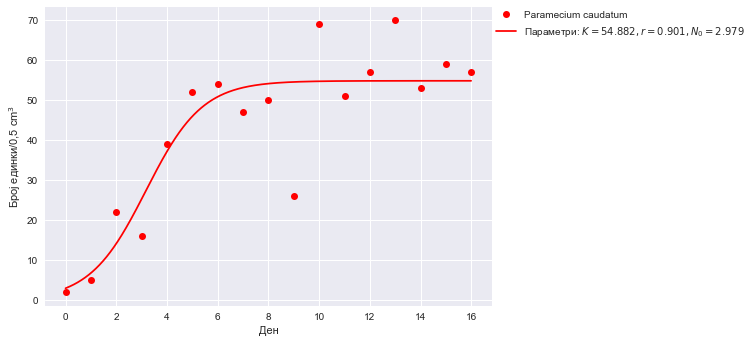

In [12]:
# Experimental data
y = par1['y'].values
 
# Plot experimental data points
plt.plot(t, y, 'ro', label='Paramecium caudatum')
 
# Initial guess for the parameters
initialGuess = [y[-1],1,1]    
 
# Perform the curve-fit
poptCaudatum, pcovCaudatum = curve_fit(f=logistic_growth, xdata=t, ydata=y, p0=initialGuess)
poptCaudatum = np.round(poptCaudatum, 5)
print(poptCaudatum)

# Plot the fitted function
plt.plot(t_calc, logistic_growth(t_calc, *poptCaudatum), 'r', label='Параметри: $K=%5.3f, r=%5.3f, N_0=%5.3f$' % tuple(poptCaudatum))
plt.xlabel('Ден')
plt.ylabel('Број единки/0,5 cm$^3$')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

#### II.2 Интерспециска конкуренција на P. aurelia и P. caudatum <a class="anchor" id="section_2_2"></a>

In [13]:
L = poptAurelia[1]
A = np.round(poptAurelia[1]/poptAurelia[0], 5)
M = poptCaudatum[1]
D = np.round(poptCaudatum[1]/poptCaudatum[0], 5)

In [14]:
x_comp = par1['x_comp'].values
y_comp = par1['y_comp'].values

In [15]:
def f_dot(x,h):
    x_dot = np.zeros_like(x)
    for k in range(1,len(x)-1):
        x_dot[k] = (1/x[k])*(x[k+h]-x[k-h])/2*h
    # End points
    x_dot[0]  = (1/x[0])*(x[1] - x[0])/h
    x_dot[-1] = (1/x[0])*(x[-1] - x[-2])/h
    return x_dot

In [16]:
x_comp_dot = f_dot(x_comp,h=1)
y_comp_dot = f_dot(y_comp,h=1)

In [17]:
gamma = x_comp * y_comp

In [18]:
zeta = x_comp*L - A*x_comp**2 - x_comp_dot

In [19]:
eta = y_comp*M - D*y_comp**2 - y_comp_dot

In [20]:
par1.insert(4, 'x_comp_dot', x_comp_dot)
par1.insert(6, 'y_comp_dot', y_comp_dot)
par1.insert(7, 'gamma', gamma)
par1.insert(8, 'zeta', zeta)
par1.insert(9, 'eta', eta)

In [21]:
par1 = np.round(par1, 5)
par1

,t,x,y,x_comp,x_comp_dot,y_comp,y_comp_dot,gamma,zeta,eta
0,0,0.78,2,0.78,1.00000,2.0,3.00000,1.56,-0.02487,-1.26446
1,1,1.17,5,1.56,3.37500,8.0,1.12500,12.48,-1.44093,5.02948
2,2,11.31,22,11.31,1.06897,20.0,0.42500,226.20,11.48529,11.02280
3,3,35.88,16,25.74,0.84848,25.0,0.08000,643.50,22.77956,12.17850
4,4,67.47,39,54.99,0.34043,24.0,-0.02083,1319.76,28.72911,12.18283
5,5,81.90,52,63.18,0.24074,24.0,0.00000,1516.32,26.27112,12.16200
6,6,81.90,54,85.41,-0.02055,24.0,-0.06250,2049.84,10.58943,12.22450
7,7,93.60,47,59.67,-0.18627,21.0,-0.07143,1253.07,28.01292,11.74701
8,8,93.60,50,63.18,-0.00926,21.0,-0.14286,1326.78,26.52112,11.81844
9,9,93.60,26,58.50,0.04333,15.0,-0.30000,877.50,28.14869,10.11660


B = 0
C = 0

alpha = 1.3
beta = 1.3

for i in range(0, par1.shape[0]-1, 1):
    B = B + np.divide(par1['gamma'].iloc[i] * par1['zeta'].iloc[i], np.power(par1['gamma'].iloc[i],2))
    
    C = C + np.divide(par1['gamma'].iloc[i] * par1['eta'].iloc[i], np.power(par1['gamma'].iloc[i],2))
    
B = np.round(alpha*B, 5)
print(B)

C = np.round(beta*C, 5)
print(C)

In [32]:
def estimate_parameters(par1: type(par1),
                        B: float,
                        C: float,
                        alpha: float,
                        beta: float
                       ) -> float:
    
    for i in range(par1.shape[0]):
        B = B + np.divide(par1['gamma'].iloc[i] * par1['zeta'].iloc[i], np.power(par1['gamma'].iloc[i],2) + alpha)
    
        C = C + np.divide(par1['gamma'].iloc[i] * par1['eta'].iloc[i], np.power(par1['gamma'].iloc[i],2) + beta)
    
    return np.round(B, 5), np.round(C, 5)

In [70]:
B = 0.0
C = 0.0
#alpha = [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000]
#beta = [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000]
alpha = np.linspace(200, 500, 10)
beta = np.linspace(1.03, 1.06, 10)

res_B = []
res_C = []

for i in range(len(alpha)):
    B_temp, C_temp = estimate_parameters(par1, B, C, alpha[i], beta[i])
    
    res_B.append(B_temp)
    res_C.append(C_temp)
    
print(f'B: {res_B}')
print(f'C: {res_C}')

B: [0.16848, 0.17278, 0.1764, 0.17947, 0.18212, 0.18442, 0.18644, 0.18822, 0.18981, 0.19123]
C: [0.00819, 0.00873, 0.00927, 0.00981, 0.01034, 0.01088, 0.01141, 0.01194, 0.01247, 0.013]


In [69]:
np.linspace(1, 1.25, 10)

array([1.        , 1.02777778, 1.05555556, 1.08333333, 1.11111111,
       1.13888889, 1.16666667, 1.19444444, 1.22222222, 1.25      ])

In [24]:
def calculate_model(L, A, B, M, C, D, t, x_comp, y_comp):
    dt = 0.01; max_time = t[-1]

    # initial time and populations
    t_el = t[0]; x_el = x_comp[0]; y_el = y_comp[0]

    # empty lists in which to store time and populations
    t_calc = []; x_calc = []; y_calc = []

    # initialize lists
    t_calc.append(t_el); x_calc.append(x_el); y_calc.append(y_el)

    while t_el < max_time:
        # calc new values for t_el, x_el, y_el
        t_el = t_el + dt
        x_el = x_el + x_el*(L - A*x_el - B*y_el)*dt
        y_el = y_el + y_el*(M - C*x_el - D*y_el)*dt

        # store new values in lists
        t_calc.append(t_el)
        x_calc.append(x_el)
        y_calc.append(y_el)
        
    return t_calc, x_calc, y_calc

In [25]:
models = dict()

for i in range(len(res_B)):
    for j in range(len(res_C)):
        models.update({'alpha='+str(alpha[i])+', beta='+str(beta[j]): [calculate_model(L, A, res_B[i], M, res_C[j], D, t, x_comp, y_comp)]})

<ipython-input-24-f80a4d367907>:16: RuntimeWarning: overflow encountered in double_scalars
  x_el = x_el + x_el*(L - A*x_el - B*y_el)*dt
<ipython-input-24-f80a4d367907>:16: RuntimeWarning: invalid value encountered in double_scalars
  x_el = x_el + x_el*(L - A*x_el - B*y_el)*dt


In [26]:
from sklearn.metrics import r2_score

x_true, x_model = x_comp, x_calc[0:len(x_calc):100]
y_true, y_model = y_comp, y_calc[0:len(y_calc):100]

NameError: name 'x_calc' is not defined

In [ ]:
r2_x = r2_score(x_true, x_model)
r2_y = r2_score(y_true, y_model)
print(r2_x, r2_y)

In [ ]:
params = {'L': L, 'A': A, 'B': B, 'M': M, 'C': C, 'D': D}
for k, v in params.items():
    print(f'{k} ---> {v}')

In [ ]:
# Experimental data
plt.plot(t, x_comp, 'bo', label='Paramecium aurelia')
plt.plot(t, y_comp, 'ro', label='Paramecium caudatum')
plt.plot(t_calc, x_calc, 'b-')
plt.plot(t_calc, y_calc, 'r-')
plt.xlabel('Ден')
plt.ylabel('Број единки/0,5 cm$^3$')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#b = np.round((1.55)*(1.12)/95, 5) #0.01827
b = 0.018
#c = np.round((0.65)*(0.84/60), 5) #0.0091
c = 0.012
print(B, b, C, c)

In [ ]:
pd.DataFrame({'x_true': x_true, 'x_model': x_model, 'y_true': y_true, 'y_model': y_model})